In [81]:
import copy
from functools import partial
from typing import *

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import wandb
import wandb.apis

api = wandb.Api()


In [82]:
def load_one(
    run: wandb.apis.public.Run, num_examples: Optional[int] = None
) -> Dict[str, Any]:
    if "count" in run.summary:
        task = run.config["task"]["name"]

        mc = run.summary["model_config"] if "model_config" in run.summary else {}
        sparsity = copy.deepcopy(run.config["sparsity"])

        if "score" in sparsity:
            score = sparsity.pop("score")
            sparsity["ann_score"] = score.pop("name")
            sparsity.update(score)

        if "index" in sparsity:
            index = sparsity.pop("index")
            for k in ["seed", "max_iter"]:
                del index[k]
            sparsity.update(index)

        duration = run.summary.get("duration")
        
        # Calculate averages only on first num_examples
        avgs = {}
        if num_examples is not None:
            assert run.summary["count"] >= num_examples

            results = run.summary.results[:num_examples]

            for k in ["prefill_length", "match", "rougeL"]:
                if k in results[0]:
                    avgs[k] = sum(x[k] for x in results) / len(results)
                else:
                    avgs[k] = None
            
            # Approximate duration
            if duration:
                duration *= num_examples / run.summary["count"]
            
        else:
            for k in ["prefill_length", "match", "rougeL"]:
                avgs[k] = run.summary.get(k)

        return dict(
            task=task,
            model_scale=run.config["model"].replace("EleutherAI/pythia-", ""),
            **sparsity,
            n_heads=mc["num_attention_heads"],
            head_size=mc["hidden_size"] // mc["num_attention_heads"],
            **avgs,
            duration=duration
        )


In [83]:
def load_sweep(experiment_names: List[str], *single_runs: str, **kwargs: Any) -> pd.DataFrame:
    return pd.DataFrame.from_dict(filter(None, (
        load_one(run, **kwargs)
        for run in api.runs(
            "research/sparse-attention", {"$or": [
                *({"config.name": e} for e in experiment_names),
                *({"display_name": n} for n in single_runs)
            ]}
        )
    )))


In [84]:
def memory_transfers_attention_only(
    s: pd.Series, count_kv: bool = True, count_index: bool = True
) -> int:
    kv_elements, index_elements = 0, 0
    if s["name"] == "dense":
        # write 1*(k, v) + read all prefill_length*(k, v)
        kv_elements = (2 + 2 * s["prefill_length"]) * s["head_size"] * s["n_heads"]

    elif s["name"] == "sparse_v":
        # write 1*(k, v) + read all prefill_length*k + read sparse_k*v
        kv_elements = (2 + s["prefill_length"] + s["k"]) * s["head_size"] * s["n_heads"]

    elif s["name"] == "eviction":
        # write 1*(k, v) + read all sparse_k*(k, v)
        kv_elements = (2 + 2 * s["k"]) * s["head_size"] * s["n_heads"]
        # read/write scores
        index_elements = 1 + 2 * s["prefill_length"]

    elif s["name"] == "ann":
        # write 1*(k, v) + read all sparse_k*(k, v)
        kv_elements = (2 + 2 * s["k"]) * s["head_size"] * s["n_heads"]
        # write index
        index_elements += (
            dict(low_rank=s["rank"], sparse_q=s["head_size"])[s["ann_score"]]
            * s["n_heads"]
        )
        # read index
        index_elements += s["prefill_length"] * s["rank"] * s["n_heads"]

    elif s["name"] == "pq":
        # write 1*(k, v) + read all sparse_k*(k, v)
        kv_elements = (2 + 2 * s["k"]) * s["head_size"] * s["n_heads"]
        # read: centroids + quantised keys
        index_elements += (
            s["n_centroids"] * s["head_size"] * s["n_heads"]
            + s["prefill_length"]
            * s["n_subvectors"]
            * s["n_heads"]
        )
        # write
        index_elements += s["n_subvectors"] * s["n_heads"]
    else:
        assert False, s["name"]

    return count_kv * kv_elements + count_index * index_elements


def technique(s: pd.Series) -> str:
    return "_".join(
        str(n) for n in [s["name"], s["strategy"], s["ann_score"]] if not pd.isna(n)
    )


In [85]:
df = (
    load_sweep(["RMOE-46-pq-attention", "RMOE-56-baselines"], num_examples=500)
    .pipe(lambda d: d.assign(score=d.match.where(~d.match.isna(), d.rougeL)))
    .pipe(lambda d: d.assign(transfers=d.apply(memory_transfers_attention_only, axis=1)))
    .pipe(lambda d: d.assign(index_transfers=d.apply(partial(memory_transfers_attention_only, count_kv=False), axis=1)))
    .pipe(lambda d: d.assign(technique=d.apply(technique, axis=1)))
    .drop(columns=["add_avg", "apply_after_softmax", "n_heads", "head_size", "prefill_length", "match", "rougeL"])
)


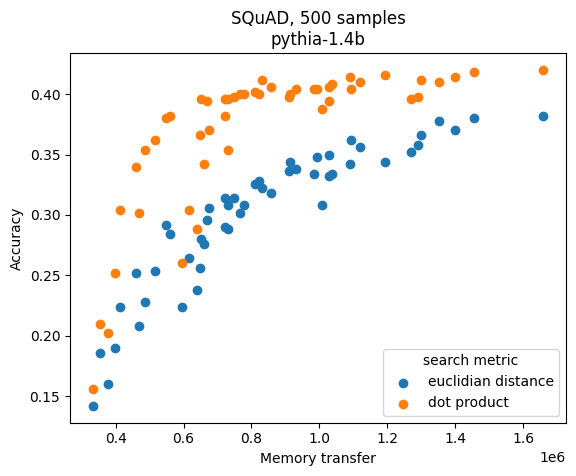

In [86]:
# Dot product search vs euclidian distance
# NOTE: Only ran both for k = 64 and k = 128
plt.figure()
for dot_product, f in df[(df["technique"] == "pq") & (df["k"].isin([64, 128]))].groupby("dot_product_search"):
    plt.scatter(f["transfers"], f["score"], label="dot product" if dot_product else "euclidian distance")
plt.legend(title="search metric")
plt.xlabel("Memory transfer")
plt.ylabel("Accuracy")
plt.title("SQuAD, 500 samples\npythia-1.4b")
plt.show()


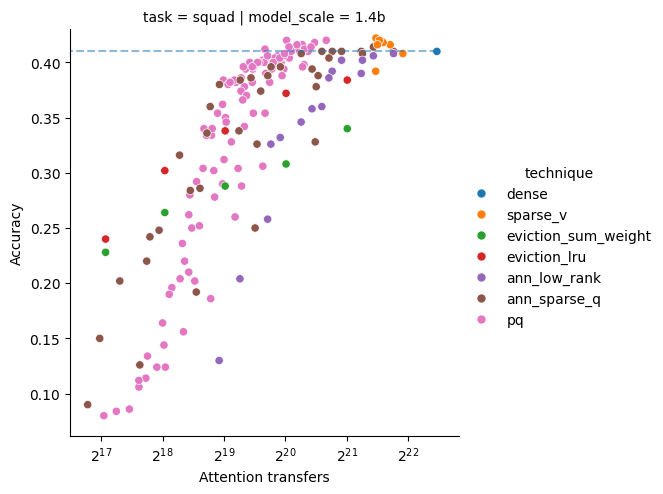

In [87]:
# NOTE: Only plot pq with dot product search
tasks = ["squad"]
models = ["1.4b"]
g = sns.relplot(data=df[df["dot_product_search"] != False], y="score", x="transfers",
                hue="technique", hue_order=["dense", "sparse_v", "eviction_sum_weight", "eviction_lru", "ann_low_rank", "ann_sparse_q", "pq"],
                row="task", row_order=tasks,
                col="model_scale", col_order=models,
                facet_kws=dict(sharex=False, sharey=False))

for (task, model_scale), ax in g.axes_dict.items():
    d = df[(df.task==task)&(df.model_scale==model_scale)&(df.technique=="dense")]
    if len(d):
        baseline = d.score.item()
        ax.hlines([baseline], *ax.get_xlim(), sns.color_palette()[0], linestyles="--", alpha=.5)
        ax.set_ylim((baseline*.15, baseline*1.05))
        ax.set_xscale("log", base=2)
        ax.set_xlabel("Attention transfers")
        ax.set_ylabel(dict(squad="Accuracy", cnn_dailymail="RougeL")[task])


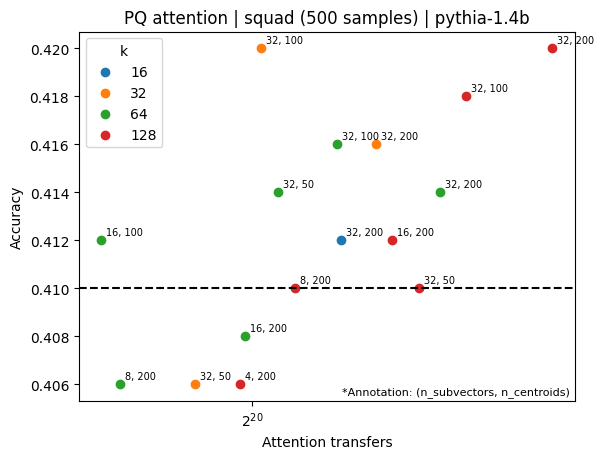

In [88]:
dense_score = df[
    (df.task == "squad") & (df.model_scale == "1.4b") & (df.technique == "dense")
].score.item()
a = df[
    (df["technique"] == "pq")
    & (df["dot_product_search"] == True)
    & (df["score"] >= 0.99 * dense_score)
]
for k, g in a.groupby("k"):
    plt.scatter(g["transfers"], g["score"], label=int(k))
    # Annotate points as (n_subvectors, n_centroids)
    for _, s in g.iterrows():
        plt.annotate(
            f"{int(s.n_subvectors)}, {int(s.n_centroids)}",
            (s.transfers, s.score),
            xytext=(5, 5),
            textcoords="offset pixels",
            fontsize=7,
        )
plt.legend(title="k")
plt.text(
    0.99,
    0.01,
    "*Annotation: (n_subvectors, n_centroids)",
    horizontalalignment="right",
    verticalalignment="bottom",
    fontsize=8,
    transform=plt.gca().transAxes,
)
plt.xscale("log", base=2)
plt.axhline(dense_score, color="black", linestyle="--")
plt.xlabel("Attention transfers")
plt.ylabel("Accuracy")
plt.title("PQ attention | squad (500 samples) | pythia-1.4b")
plt.show()


Run time:

In [89]:
other = df[(df["task"] == "squad") & (df["k"] == 64) & (df["technique"] != "pq") & (df["model_scale"] == "1.4b")]
# Note: original runs were >= 500 samples, so duration was scaled to get approximate time for 500 samples
print(f"Mean run duration: {other['duration'].mean()}")
other


Mean run duration: 177.07745611667633


,task,model_scale,k,name,local_k,n_centroids,n_subvectors,dot_product_search,duration,strategy,ann_score,rank,score,transfers,index_transfers,technique
290,squad,1.4b,64.0,ann,16.0,NaN,NaN,NaN,167.159152,NaN,sparse_q,8.0,0.360,448742.4,182502.4,ann_sparse_q
291,squad,1.4b,64.0,ann,16.0,NaN,NaN,NaN,165.907255,NaN,sparse_q,4.0,0.284,358515.2,92275.2,ann_sparse_q
477,squad,1.4b,64.0,ann,16.0,NaN,NaN,NaN,175.966745,NaN,sparse_q,64.0,0.404,1711923.2,1445683.2,ann_sparse_q
478,squad,1.4b,64.0,ann,16.0,NaN,NaN,NaN,179.873165,NaN,low_rank,64.0,0.386,1710899.2,1444659.2,ann_low_rank
479,squad,1.4b,64.0,ann,16.0,NaN,NaN,NaN,171.733065,NaN,sparse_q,32.0,0.396,990105.6,723865.6,ann_sparse_q
480,squad,1.4b,64.0,ann,16.0,NaN,NaN,NaN,177.742737,NaN,low_rank,32.0,0.332,988569.6,722329.6,ann_low_rank
481,squad,1.4b,64.0,ann,16.0,NaN,NaN,NaN,169.080542,NaN,sparse_q,16.0,0.384,629196.8,362956.8,ann_sparse_q
482,squad,1.4b,64.0,ann,16.0,NaN,NaN,NaN,176.765690,NaN,low_rank,16.0,0.204,627404.8,361164.8,ann_low_rank
483,squad,1.4b,64.0,eviction,16.0,NaN,NaN,NaN,226.164480,lru,NaN,NaN,0.302,269060.6,2820.6,eviction_lru
484,squad,1.4b,64.0,eviction,16.0,NaN,NaN,NaN,174.976479,sum_weight,NaN,NaN,0.264,269060.6,2820.6,eviction_sum_weight


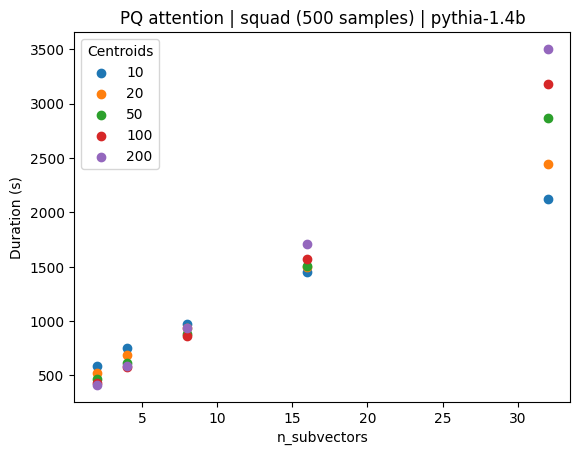

In [90]:
a = df[(df["technique"] == "pq") & (df["k"] == 64) & (df["dot_product_search"] == True)]
for n_centroids, g in a.groupby("n_centroids"):
    plt.scatter(g["n_subvectors"], g["duration"], label=int(n_centroids))
plt.legend(title="Centroids")
plt.title("PQ attention | squad (500 samples) | pythia-1.4b")
plt.xlabel("n_subvectors")
plt.ylabel("Duration (s)")
plt.show()


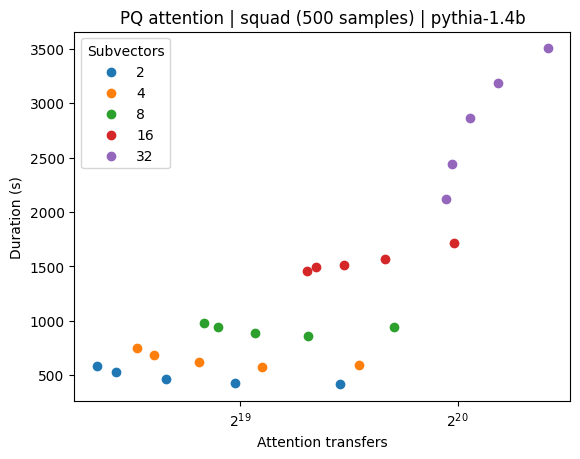

In [91]:
a = df[(df["technique"] == "pq") & (df["k"] == 64) & (df["dot_product_search"] == True)]
for n_subvectors, g in a.groupby("n_subvectors"):
    plt.scatter(g["transfers"], g["duration"], label=int(n_subvectors))
plt.legend(title="Subvectors")
plt.title("PQ attention | squad (500 samples) | pythia-1.4b")
plt.xscale("log", base=2)
plt.xlabel("Attention transfers")
plt.ylabel("Duration (s)")
plt.show()
